In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain, read_eqdsk, create_isoflux


In [2]:
def corners(r,z,dr,dz):
    rs = np.array([r+dr/2, r+dr/2, r-dr/2, r-dr/2, r+dr/2])
    zs = np.array([z+dz/2, z-dz/2, z-dz/2, z+dz/2, z+dz/2])
    return np.column_stack((rs,zs))

In [3]:
lim2 = np.array([[ 1.36295616,  0.        ],
       [ 1.35819627,  0.1136394 ],
       [ 1.34411987,  0.22839392],
       [ 1.32147837,  0.33535708],
       [ 1.29160087,  0.428733  ],
       [ 1.25659351,  0.50348616],
       [ 1.21989537,  0.55532746],
       [ 1.18721657,  0.58207902],
       [ 1.16129551,  0.58932473],
       [ 1.0702428 ,  0.57841675],
       [ 0.97292215,  0.544273  ],
       [ 0.88082552,  0.48851609],
       [ 0.79867131,  0.41333246],
       [ 0.73043826,  0.32194035],
       [ 0.67936479,  0.2185339 ],
       [ 0.64782749,  0.10834806],
       [ 0.63723823,  0.        ],
       [ 0.64782749, -0.10834806],
       [ 0.67936479, -0.2185339 ],
       [ 0.73043826, -0.32194035],
       [ 0.79867131, -0.41333246],
       [ 0.88082552, -0.48851609],
       [ 0.97292215, -0.544273  ],
       [ 1.0702428 , -0.57841675],
       [ 1.16129551, -0.58932473],
       [ 1.18721657, -0.58207902],
       [ 1.21989537, -0.55532746],
       [ 1.25659351, -0.50348616],
       [ 1.29160087, -0.428733  ],
       [ 1.32147837, -0.33535708],
       [ 1.34411987, -0.22839392],
       [ 1.35819627, -0.1136394 ]])

vv2 = np.array([[ 1.37296493e+00, -1.38777878e-17],
       [ 1.36817072e+00,  1.14458731e-01],
       [ 1.35399275e+00,  2.30041200e-01],
       [ 1.33115684e+00,  3.37922814e-01],
       [ 1.30092944e+00,  4.32392306e-01],
       [ 1.26527112e+00,  5.08535482e-01],
       [ 1.22727606e+00,  5.62208864e-01],
       [ 1.19192830e+00,  5.91145285e-01],
       [ 1.16207641e+00,  5.99489787e-01],
       [ 1.06796580e+00,  5.88215468e-01],
       [ 9.68631600e-01,  5.53365296e-01],
       [ 8.74802348e-01,  4.96559420e-01],
       [ 7.91223325e-01,  4.20071879e-01],
       [ 7.21877594e-01,  3.27189432e-01],
       [ 6.69999158e-01,  2.22153185e-01],
       [ 6.37963346e-01,  1.10225658e-01],
       [ 6.27190584e-01, -6.93889390e-18],
       [ 6.37963346e-01, -1.10225658e-01],
       [ 6.69999158e-01, -2.22153185e-01],
       [ 7.21877594e-01, -3.27189432e-01],
       [ 7.91223325e-01, -4.20071879e-01],
       [ 8.74802348e-01, -4.96559420e-01],
       [ 9.68631600e-01, -5.53365296e-01],
       [ 1.06796580e+00, -5.88215468e-01],
       [ 1.16207641e+00, -5.99489787e-01],
       [ 1.19192830e+00, -5.91145285e-01],
       [ 1.22727606e+00, -5.62208864e-01],
       [ 1.26527112e+00, -5.08535482e-01],
       [ 1.30092944e+00, -4.32392306e-01],
       [ 1.33115684e+00, -3.37922814e-01],
       [ 1.35399275e+00, -2.30041200e-01],
       [ 1.36817072e+00, -1.14458731e-01]])

In [4]:
coils = {
    'CS0': {'rc': 0.550, 'zc': -.63, 'w': 0.1, 'h': 0.4},
    'CS1': {'rc': 0.550, 'zc': 0, 'w': 0.1, 'h': 0.8},
    'CS2': {'rc': 0.550, 'zc': .63, 'w': 0.1, 'h': 0.4},

    'EF0U': {'rc': .738, 'zc': 0.6, 'w': 0.15, 'h': 0.15},
    'EF1U': {'rc': 1.250, 'zc': 0.74, 'w': 0.175, 'h': 0.175},
    'EF2U': {'rc': 1.450, 'zc': 0.600, 'w': 0.15, 'h': 0.15},
    'EF3U': {'rc': 1.95, 'zc': 0.3, 'w': .175, 'h': .175},

    'EF0L': {'rc': .738, 'zc': -0.6, 'w': 0.15, 'h': 0.15},
    'EF1L': {'rc': 1.250, 'zc': -0.74, 'w': 0.175, 'h': 0.175},
    'EF2L': {'rc': 1.450, 'zc': -0.600, 'w': 0.15, 'h': 0.15},
    'EF3L': {'rc': 1.95, 'zc': -0.3, 'w': .175, 'h': .175},
  
}

In [5]:
## Define mesh resolution in each region
plasma_resolution = 0.02
coil_resolution = 0.04
vv_resolution = 0.03
vac_resolution = 0.075

In [6]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_resolution,'boundary')
gs_mesh.define_region('plasma',plasma_resolution,'plasma')
gs_mesh.define_region('vv',vv_resolution,'conductor',eta=8.67E-7)
# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_resolution,'coil')

In [7]:
# Define vaccum vessel geometry
gs_mesh.add_annulus(lim2,'plasma',vv2,'vv',parent_name='air')
# Define the shape of the coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')


In [8]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 574
  # of unique segments  = 50
Generating mesh:
  # of points  = 4201
  # of cells   = 8284
  # of regions = 14


#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.870E+00
    # of points  =    4201
    # of edges   =   12484
    # of cells   =    8284
    # of boundary points =     116
    # of boundary edges  =     116
    # of boundary cells  =     116
  Resolution statistics:
    hmin =  1.000E-02
    hrms =  3.913E-02
    hmax =  1.119

/var/folders/hx/px24dh2d0bv8fs3t0c3v7ymm0000gn/T/ipykernel_45881/3781663684.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


 Inverting real matrix
   Time =    1.5110000000000000E-003
Starting non-linear GS solver
     1  1.3219E+01  6.3952E+00  2.2462E-02  1.0280E+00  8.8374E-06 -0.0000E+00
     2  1.4284E+01  6.8781E+00  1.2455E-02  1.0306E+00  5.6330E-06 -0.0000E+00
     3  1.4693E+01  7.0577E+00  5.6014E-03  1.0320E+00  2.4590E-06 -0.0000E+00
     4  1.4911E+01  7.1525E+00  2.6698E-03  1.0328E+00  9.0247E-07 -0.0000E+00
     5  1.5034E+01  7.2052E+00  1.3533E-03  1.0333E+00  3.9890E-07 -0.0000E+00
     6  1.5103E+01  7.2348E+00  7.1447E-04  1.0335E+00  4.7957E-07 -0.0000E+00
     7  1.5143E+01  7.2515E+00  3.8649E-04  1.0337E+00  9.3627E-07 -0.0000E+00
     8  1.5165E+01  7.2609E+00  2.1222E-04  1.0338E+00  1.5533E-06 -0.0000E+00
     9  1.5178E+01  7.2662E+00  1.1773E-04  1.0338E+00  2.2201E-06 -0.0000E+00
    10  1.5185E+01  7.2692E+00  6.5827E-05  1.0339E+00  2.8862E-06 -0.0000E+00
    11  1.5189E+01  7.2708E+00  3.7037E-05  1.0339E+00  3.5224E-06 -0.0000E+00
    12  1.5192E+01  7.2718E+00  2.0957E-0

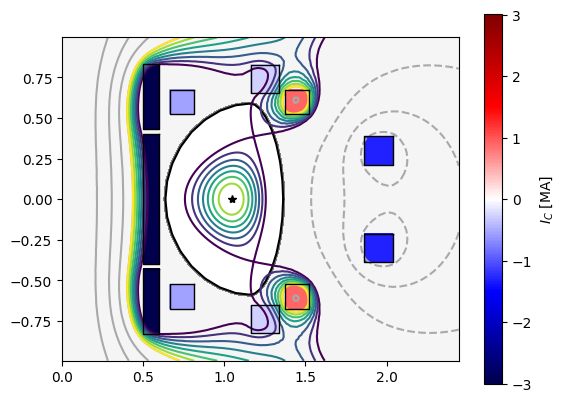

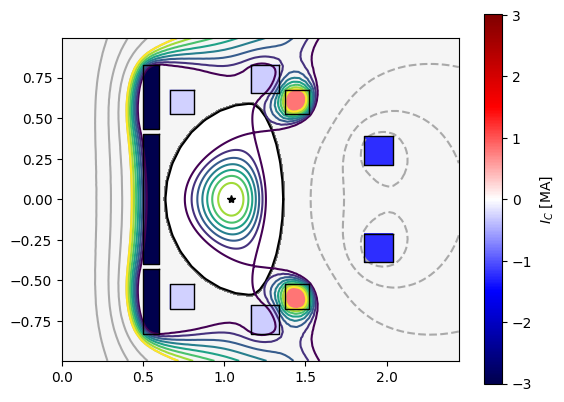

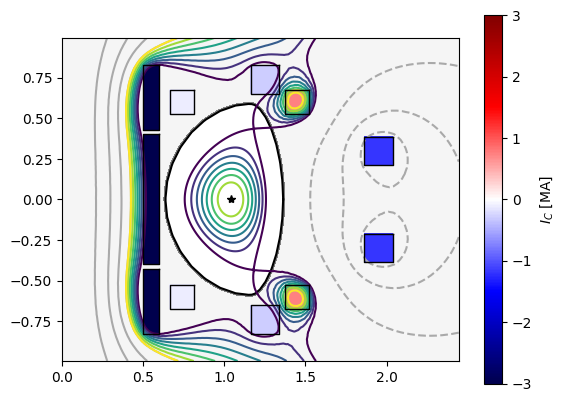

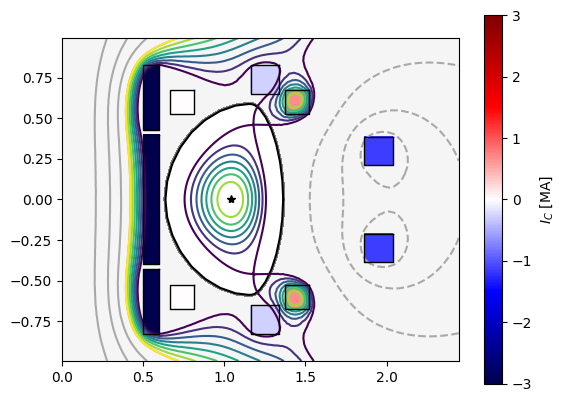

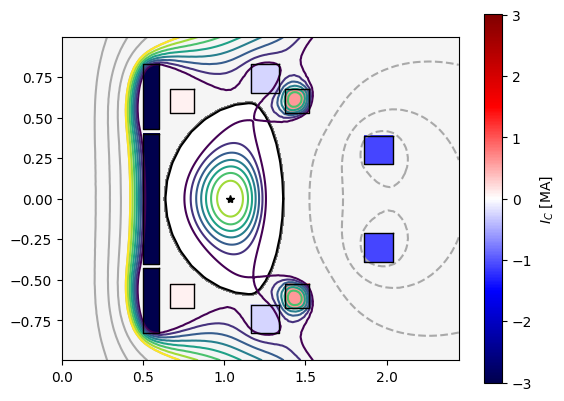

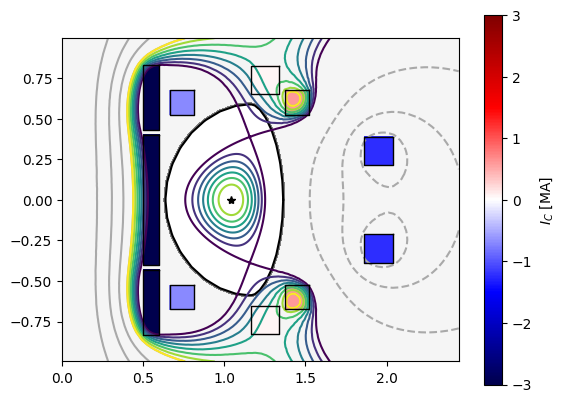

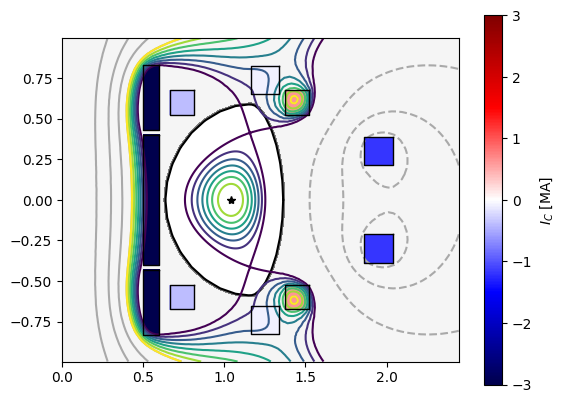

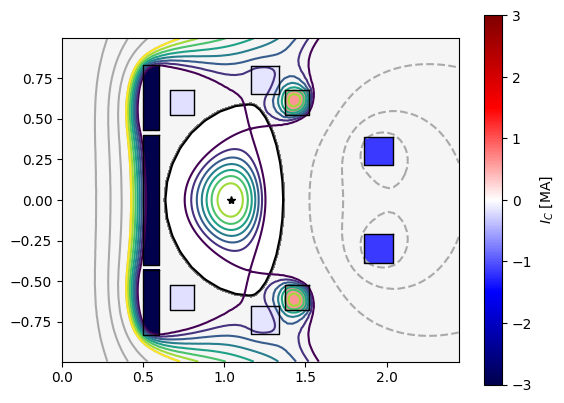

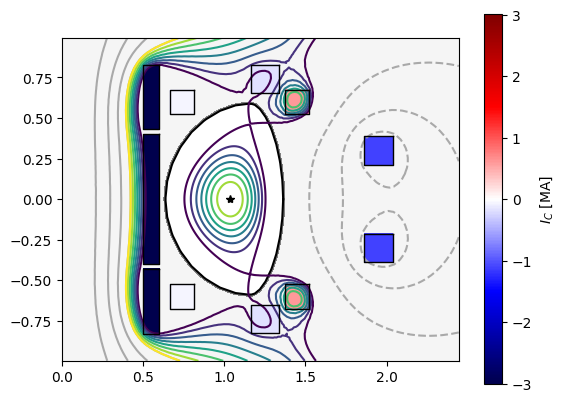

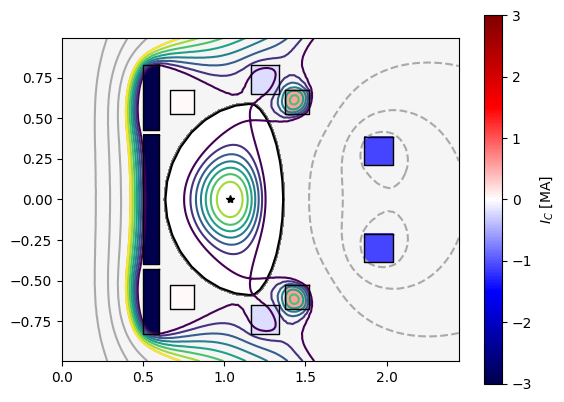

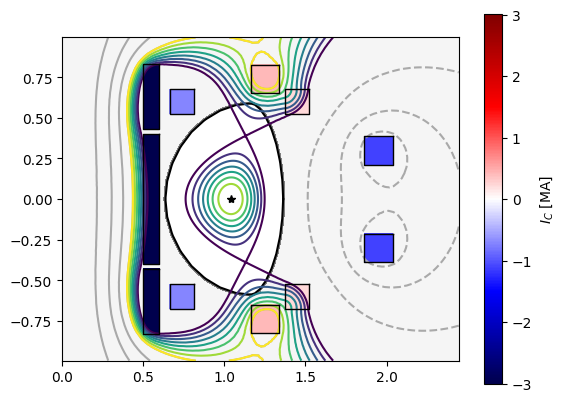

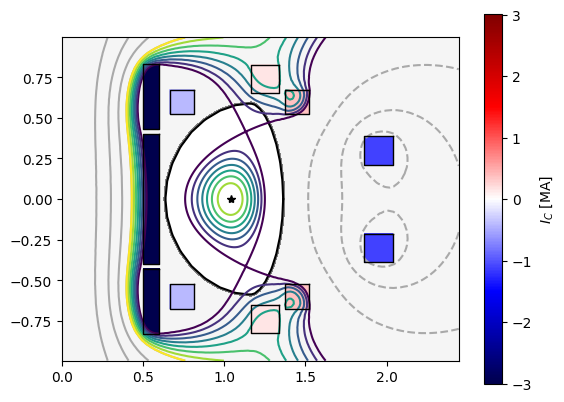

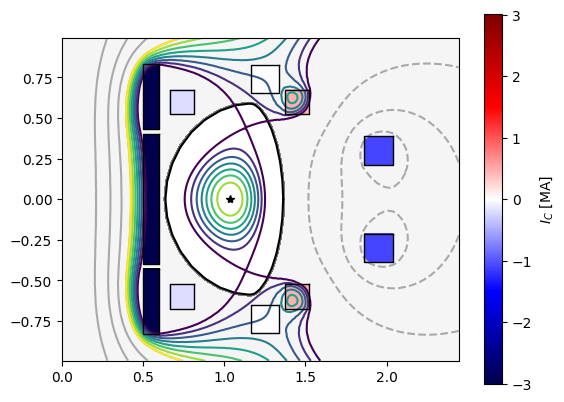

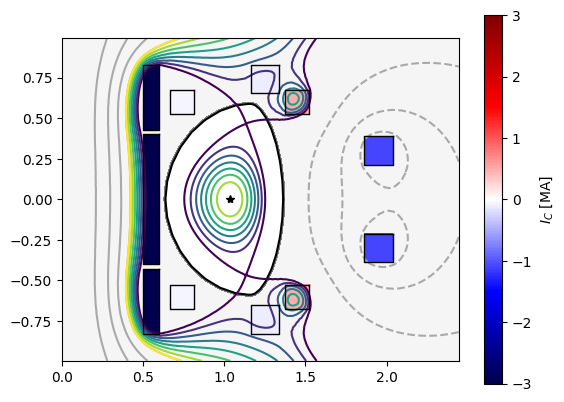

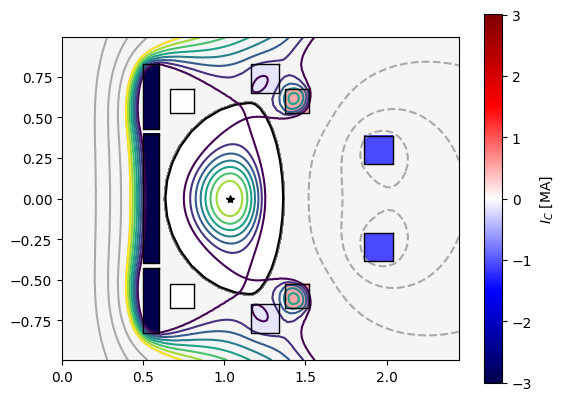

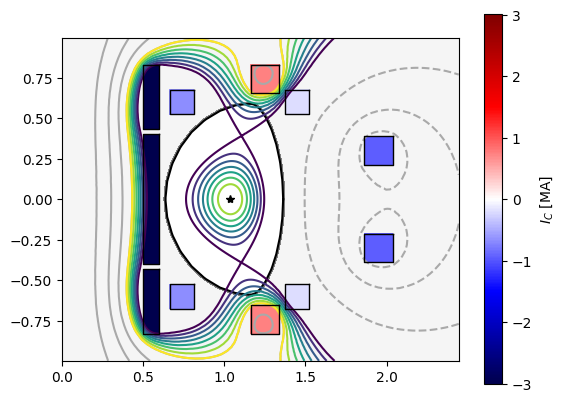

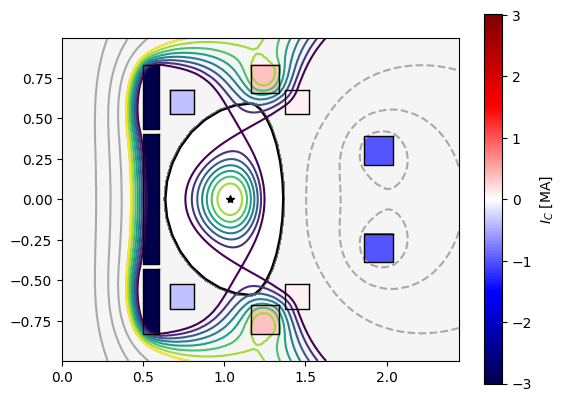

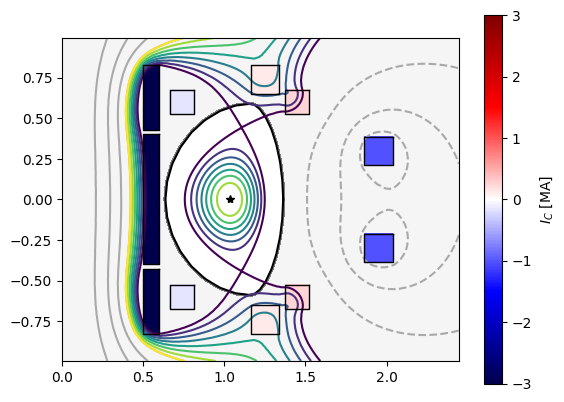

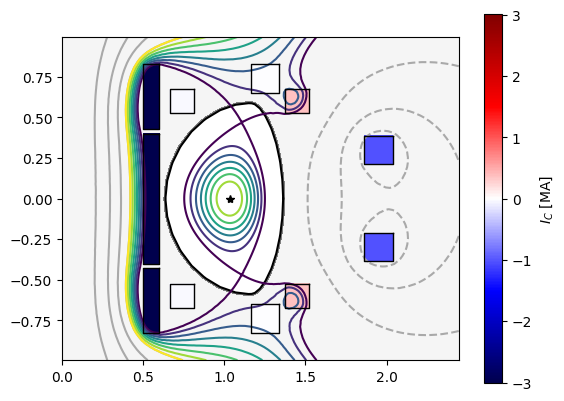

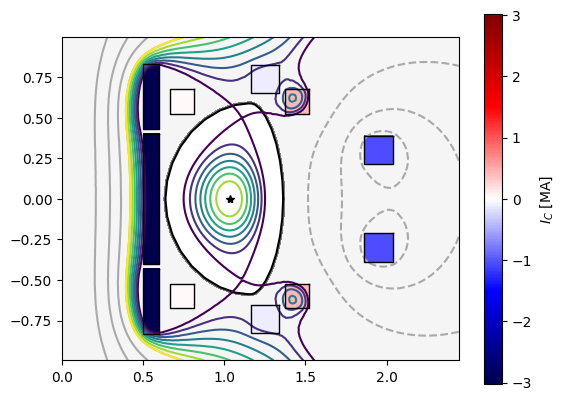

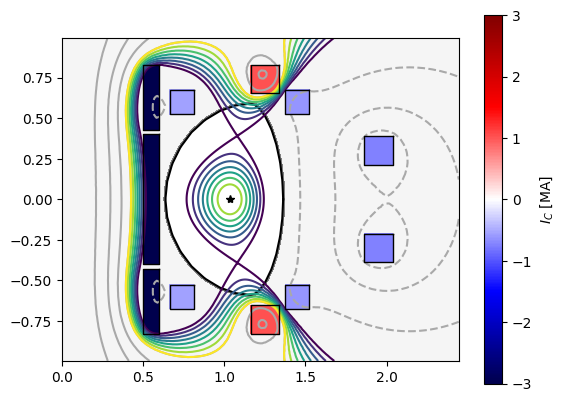

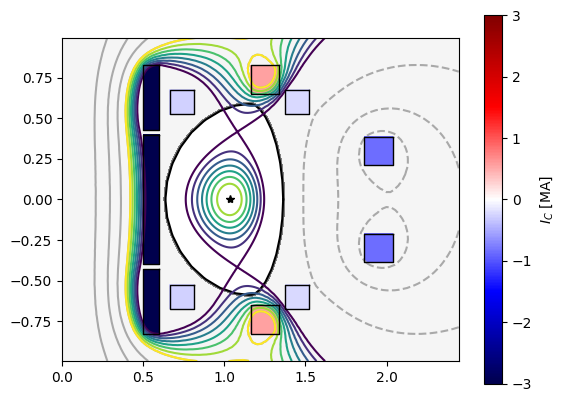

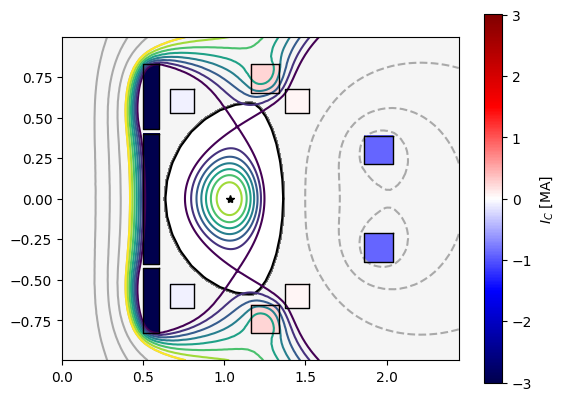

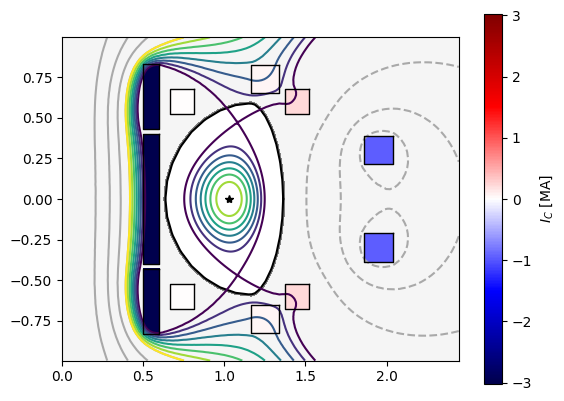

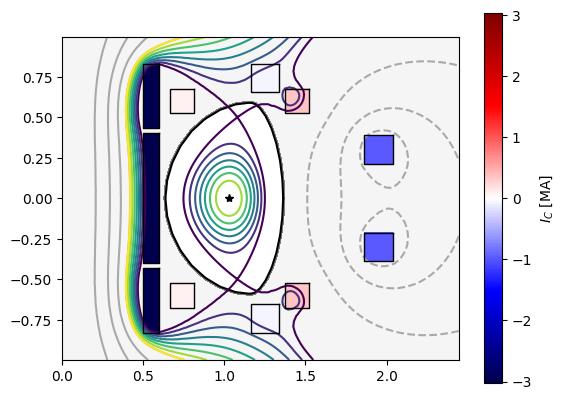

In [9]:
import copy
d_omfit = []
e_omfit = []
d_tok = []
e_tok = []
q95 = []
betap = []
li = []
coil_currents = []
ds = np.linspace(-0.7, -.3, 5)
es = np.linspace(1.5, 1.9, 5)
dist = []
gammas = []
taus = []
eqdsks = []
lcfs = []


for d in ds: 
    for e in es:
        mygs = TokaMaker()
        mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
        mygs.setup_regions(cond_dict=cond_dict)
        mygs.setup(order = 2, F0 =1*3) ## F0 = B0 * R0

        coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
        targets = np.zeros(mygs.ncoils+1)
        coil_weights = 0.5*np.ones(mygs.ncoils+1)

        #Set target values for CS coils
        coil_reg_mat[0,0] = 1
        coil_reg_mat[1,1] = 1
        coil_reg_mat[2,2] = 1
        targets[0] = -3E6
        targets[1] = -3E6
        targets[2] = -3E6

        #Enforce up/down symmetry in PF coils
        coil_reg_mat[3,3] = 1
        coil_reg_mat[3,7] = -1
        coil_reg_mat[4,4] = 1
        coil_reg_mat[4,8] = -1
        coil_reg_mat[5,5] = 1
        coil_reg_mat[5,9] = -1
        coil_reg_mat[6,6] = 1
        coil_reg_mat[6,10] = -1
        mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

        #Set upper bound on coil currents
        coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
        coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
        mygs.set_coil_bounds(coil_bounds)

        # Define shape of P' anf FF' profiles
        n_sample = 40
        psi_sample = np.linspace(0.0,1.0,n_sample)
        # Set F*F' profile
        alpha = 2
        gamma = 3
        ffp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
        # Set P' profile
        alpha = 2
        gamma = 3
        pp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

        mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

        # set global targets
        Ip_target = 1E6
        mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

        # set boundary/saddle point targets
        boundary = create_isoflux(20, 1, 0, 0.2588, e, d)
        x_points = np.zeros((2,2))
        x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
        x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
        x_weights = 5*np.ones(2)
        mygs.set_saddles(x_points, x_weights)
        isoflux_weights = 10*np.ones(len(boundary))

      
        
        mygs.set_isoflux(boundary, isoflux_weights)

        #find equilibrium
        mygs.init_psi(0.68,0,0.2, 1.8,0.3)
        mygs.settings.maxits = 100
        mygs.update_settings()
        mygs.solve()

        #plot equilibrium
        fig, ax = plt.subplots(1,1)
        mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
        mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
        
        for key, coil in coils.items():
            plt.plot(corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,0],corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,1], color = 'k', linewidth = 1)

        mygs.reset()
        